# Assignment 1 MTA Cardtype Timeseries Analysis Part II
yg833

This assignment is a continuation from the week prior.For this week, I worked with QY(qg412) and Tiffany (tp1600)

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


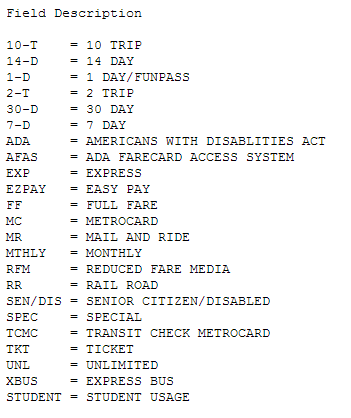

In [25]:
from __future__ import print_function, division
import os
import sys
import urllib
import io

import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# read in data as instructed above

In [123]:
# setting environmental variable
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print(os.environ["PUIDATA"])

/nfshome/yg833/PUIdata


In [124]:
# url for mta fare data
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare_py3.npy' 

# retrieve csv file from the url
urllib.request.urlretrieve(url, 'MTA_Fare_py3.npy')

('MTA_Fare_py3.npy', <http.client.HTTPMessage at 0x7f9877294518>)

In [125]:
# move the file to PUIData folder
!mv MTA_Fare_py3.npy $PUIDATA

In [126]:
mta = np.load(os.environ["PUIDATA"]+'/MTA_Fare_py3.npy')

In [127]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [128]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [129]:
# convert the mta cube with -1s  into float and convert to nans
mta = mta[:].astype(float)

You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [130]:
dates_studied = pd.date_range(start = '2010/05/19', periods=194, freq='W-WED') # creats a date range for this analysis

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

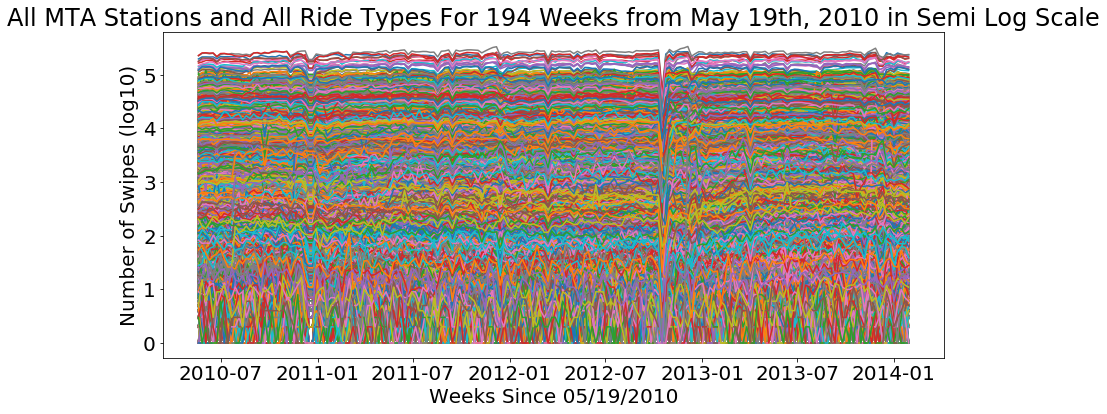

In [131]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(dates_studied,np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 1: Time series for all rides types and all stations in semi-log space. This plot is kind of messy and hard to read but despite it one can still see that there is a dip towards the end of 2012 where the x-axis shows the date range. 

# Task 4: Fourier transform
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**

from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [167]:
mta[mta == -1] = np.nan # classifying the -1s into nans

In [168]:
# find the location for nans in the time series
find_nans = np.any(np.isnan(mta), axis = 1)
shape(find_nans)

(600, 194)

In [169]:
station_sums = np.nansum(mta, axis=1) # sum per station across 194 weeks
print(shape(station_sums), '\n', station_sums)

(600, 194) 
 [[126878. 149477. 152383. ...  78901.  74591.  76833.]
 [ 37306.  46464.  49359. ...      0.      0.      0.]
 [  6606.   6881.   7229. ...   8171.   7907.   6790.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]


In [170]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT) 
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).
# 600 stations, find rfft per station
station_dft = (np.abs(np.fft.rfft(station_sums, axis = 1))**2) # power spectrum, square for absolute value

# https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb
print(shape(station_dft), '\n', station_dft)

(600, 98) 
 [[5.36381339e+14 7.20272646e+12 1.85938937e+12 ... 3.21601762e+10
  4.49887441e+09 3.41207395e+10]
 [1.60682967e+13 5.17107026e+12 9.11181544e+10 ... 3.04754758e+08
  2.62383960e+09 3.05786880e+09]
 [1.97504516e+12 1.37886011e+06 3.89486562e+09 ... 1.74185456e+08
  2.08109487e+08 8.20822500e+06]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [171]:
N = len(mta[0][0])
N
# since we are measuring in weeks, the smallest unit would be 2 weeks

194

There are n=194 datapoints in the series


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

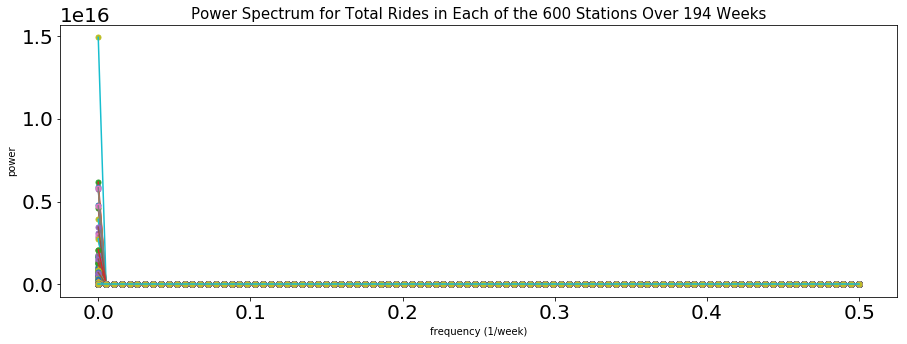

In [172]:
# plot all 600 stations from the series named station_dft (discreet fourier transformations)

print ("There are n=%d datapoints in the series"%N)

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0), station_dft[i], '-')

pl.xlabel('frequency (1/week)', fontsize=10)
pl.ylabel('power', fontsize=10)
pl.title('Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks', fontsize=15)

### Figure 2: In the power spectrum above of total rides for each of the 600 stations over 194 week, we see on the x-axis is in units of inverse frequencies. Therefore further from the 0,0 point, its 2 weeks (the smallest unit).

In [173]:
print (" The first two frequency (slowest) calculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate id every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

 The first two frequency (slowest) calculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.005154639175257732 = period: every 194.0 weeks


The fastest frequency you can calculate id every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


#### mg note: seeing the above for slowest, it makes sense to drop the first index value which is inf

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

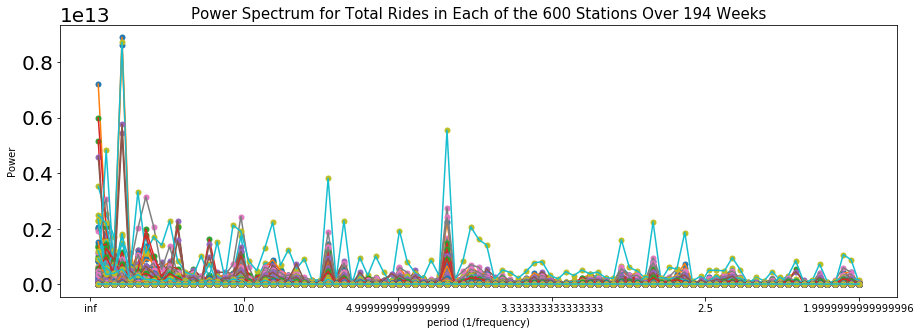

In [174]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

# pl.xlim(0,0.05)
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (1/frequency)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 3: From the above chart, it seems like the high periodicity still near inf. So will zoom in once more

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

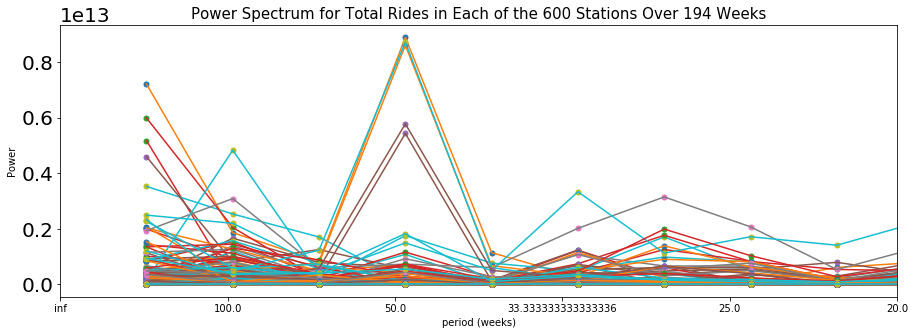

In [175]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10) 
pl.xlabel("period (weeks)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

### Figure 4: In the above plot the first value of the FFT is dropped, and zoomed into the weeks. Showing that at around 50 weeks, there is high periodicity

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks')

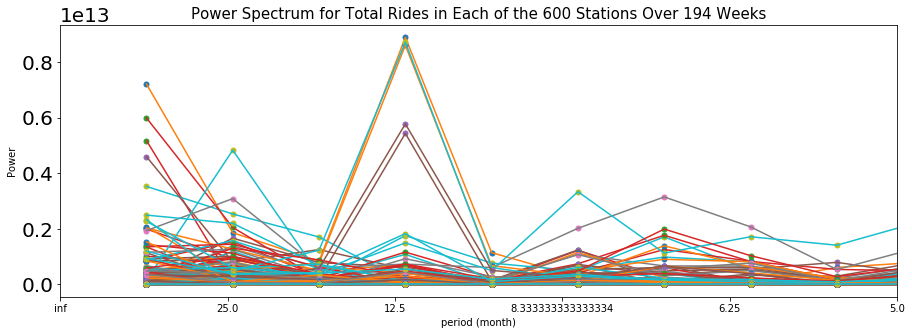

In [176]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(station_sums)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (station_dft[i][1:]), '-')

pl.xlim(0, 0.05) # just zooming into the graph
# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/4/f) for f in ax.get_xticks()], fontsize=10)  # divide by 4 because to get the months from 33 weeks
pl.xlabel("period (month)", fontsize=10)
pl.ylabel("Power", fontsize=10)
pl.title("Power Spectrum for Total Rides in Each of the 600 Stations Over 194 Weeks", fontsize=15)

#### Figure 5: Adjusting the x-scale figure plot 4 to read months. So its just about 12 months where we see high periodicity

### Identify Stations

From the charts above, we see that there is high periodicity at about 52 weeks. We want to find where the top 4 stations demonstrating the highest periodicity at each 52 weeks. 

In [198]:
freq = np.fft.rfftfreq(N, 1.0)
shape(freq)

(98,)

In [199]:
freq[4] # the value at the highest power was at the 4th point in the x-axis therefore need to find the values corresponding to the y

0.020618556701030927

In [200]:
expected_freq = 1/52
expected_freq # because on annual period so freq is 1/52

0.019230769230769232

The freq and the expected freq is similar at the 4th index. So find 4th

In [201]:
find_4th = np.empty([600])
for i in range(len(station_dft)):
    find_4th[i] = station_dft[i][4]

In [202]:
find_4th.argsort()[-4:][::-1] # the index of the stations sorted by highest power values

array([  0, 194, 150, 327])

In [203]:
ided_stations = [0, 194, 150, 327]
len(ided_stations)
ided_stations[3]

327

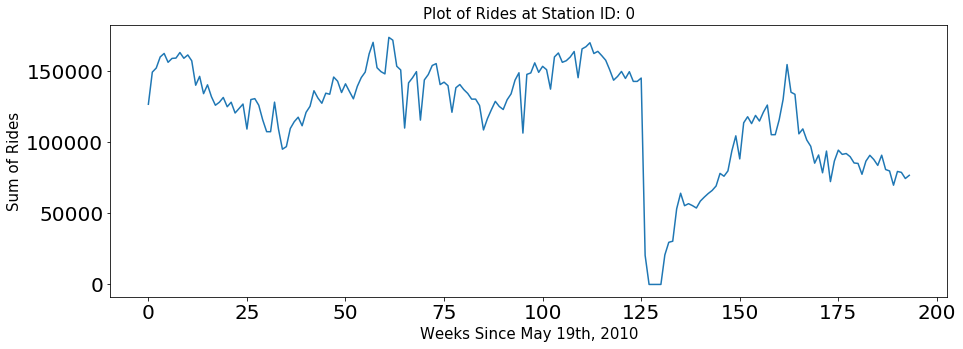

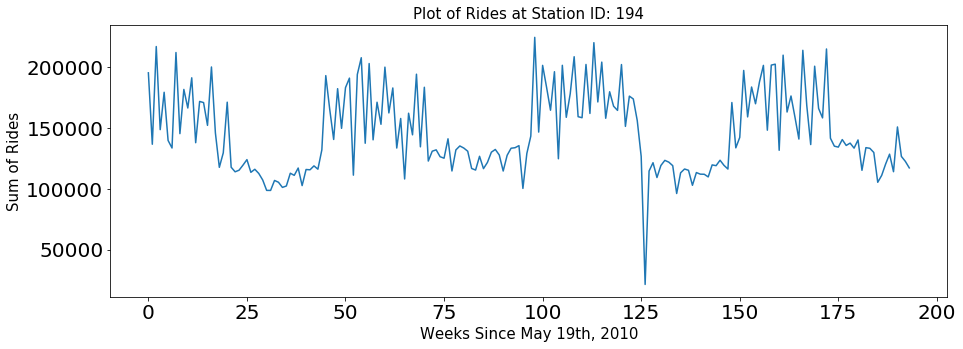

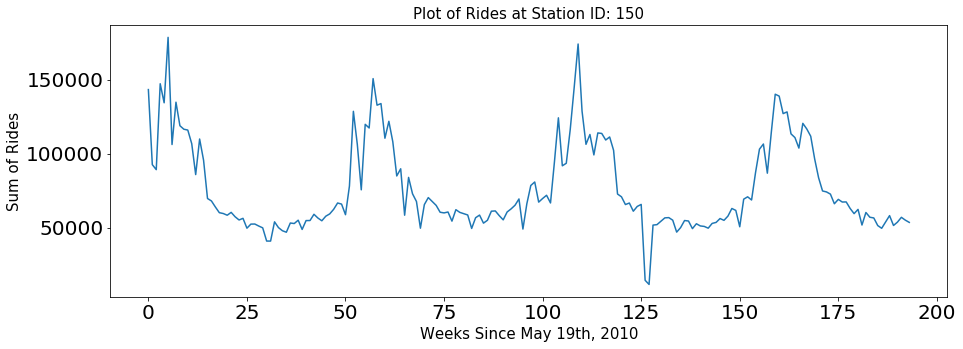

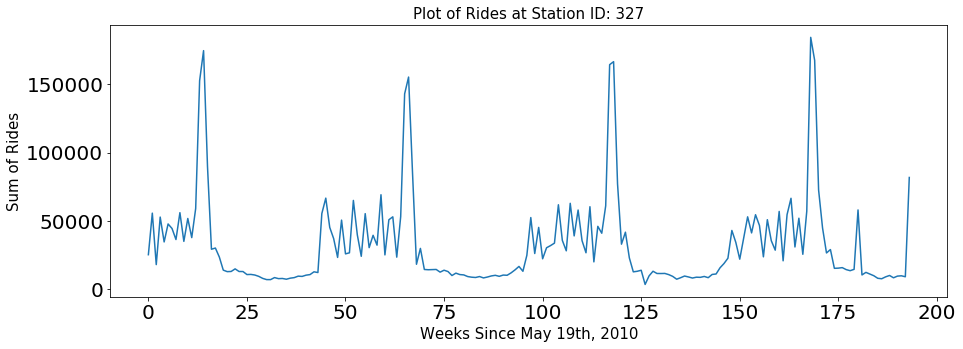

In [204]:
for i in range(0, 4):
    fig=pl.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    ax.plot(station_sums[ided_stations[i]])
    pl.xlabel("Weeks Since May 19th, 2010", fontsize=15)
    pl.ylabel("Sum of Rides", fontsize=15)
    pl.title("Plot of Rides at Station ID: " + str(ided_stations[i]) , fontsize=15)

### Figure 6: Plot of each of the identified stations to further inspect for periodicity for the duration of sum rides from May 19, 2010


# Task 5: Extra Credit
**Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:**
- are there distinct clusters?
- do they reflect the card type or station? 

To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: 
subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead: 

observation = (observation -observation.mean()) / observation.std()
each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

see this regarding whitening: https://github.com/fedhere/UInotebooks/blob/master/cluster/whitening.md